# Welcome 

Notebooks by BlazingSQL is a high-performance Jupyter lab experience. Utilizing CUDA GPUs and the RAPIDS AI ecosystem, you can scale your data science to tackle enterprise scale challenges in an easy to share, reproducable environment.

<details><summary>Instance details...</summary>

Every Notebooks environment has:
    
- An allocated CUDA GPU
    - Optional access to multi-GPU servers (COMING SOON - [join waitlist](https://google.com)) 
- Pre-Installed GPU Data Science Packages 
    - BlazingSQL, Dask, PyTorch, RAPIDS, & more
- Anaconda access to all of your favorite libraries & packages 

Our vision is to create an affordably scaleable workspace for data science that is incredibly performant and opens the door to optimized workflows. Thank you for your participation in this Alpha version. Check out our [introductory video](https://youtu.be/yqFa4_--dMQ), or start running GPU-accelerated code below!

</details>

## BlazingContext API

<details><summary>Learn more...</summary>
    
BlazingContext is the Python API of BlazingSQL. 
    
Initializing BlazingContext connects allows you to create tables, run queries and utilize the power of GPU accelerated SQL.

[GitHub](https://github.com/BlazingDB/blazingsql) | [Intro Notebook](intro_notebooks/blazingcontext.ipynb)

</details>


In [1]:
from blazingsql import BlazingContext

# connect to BlazingSQL w/ BlazingContext API
bc = BlazingContext(pool=False)

BlazingContext ready


In [2]:
%%time
# identify full file path to sample_taxi.csv
import os
data_path = f'{os.getcwd()}/data/sample_taxi.csv'

# create a BlazingSQL table from any file w/ .create_table(table_name, file_path)
bc.create_table('taxi', data_path, header=0)

CPU times: user 11.7 ms, sys: 3.13 ms, total: 14.8 ms
Wall time: 20.6 ms


Learn more about [creating](intro_notebooks/create_tables.ipynb) and [querying](intro_notebooks/query_tables.ipynb) BlazingSQL tables, or the [BlazingContext API](intro_notebooks/blazingcontext.ipynb).

## Handoff Results

BlazingContext returns each query's results as a cuDF DataFrame, making for easy handoff to GPU or non-GPU solutions.

#### cuDF - GPU DataFrame Library

<details><summary>Learn more...</summary>

Built based on the Apache Arrow columnar memory format, cuDF is a GPU DataFrame library for loading, joining, aggregating, filtering, and otherwise manipulating data.

cuDF provides a pandas-like API that will be familiar to data engineers & data scientists, so they can use it to easily accelerate their workflows without going into the details of CUDA programming.
    
[GitHub](https://github.com/rapidsai/cudf) | [Intro Notebook](intro_notebooks/bsql_cudf.ipynb)

</details>

In [3]:
type(bc.sql('select * from taxi'))

cudf.core.dataframe.DataFrame

In [4]:
# tell me about this taxi data
bc.sql('select * from taxi').describe()

,VendorID,passenger_count,trip_distance,RatecodeID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,pickup_x,pickup_y,dropoff_x,dropoff_y
count,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,743660.000000,7.436600e+05,743660.000000,7.436600e+05,743660.000000
mean,1.525276,1.684122,2.438375,1.009792,1.386322,10.461110,0.314944,0.498963,1.371924,0.143049,0.283160,13.089308,-8.235241e+06,66.699768,-8.235036e+06,66.700205
std,0.499361,1.342531,112.263296,0.531832,0.497349,6.782792,0.366628,0.025576,1.790907,0.903754,0.069053,8.328625,2.629017e+03,0.043248,2.794780e+03,0.048477
min,1.000000,0.000000,0.000000,1.000000,1.000000,-52.000000,-1.000000,-0.500000,-81.000000,-5.330000,0.000000,-116.220000,-8.254080e+06,66.555036,-8.254188e+06,66.555036
25%,1.000000,1.000000,0.980000,1.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.000000,0.300000,8.000000,-8.236756e+06,66.670758,-8.236700e+06,66.669474
50%,2.000000,1.000000,1.600000,1.000000,1.000000,8.500000,0.000000,0.500000,1.000000,0.000000,0.300000,10.800000,-8.235656e+06,66.702562,-8.235500e+06,66.703020
75%,2.000000,2.000000,2.700000,1.000000,2.000000,12.500000,0.500000,0.500000,2.000000,0.000000,0.300000,15.300000,-8.234201e+06,66.729173,-8.233834e+06,66.731232
max,2.000000,9.000000,92000.900000,99.000000,4.000000,900.000000,7.000000,0.500000,200.000000,117.820000,0.300000,900.300000,-8.210358e+06,66.870206,-8.209846e+06,66.870176


Learn more about [BlazingSQL + cuDF](intro_notebooks/bsql_cudf.ipynb) BlazingSQL tables.

#### Data Vizualization

matplotlib, datashader, HoloViews 

<details><summary>Learn more...</summary>

</details>

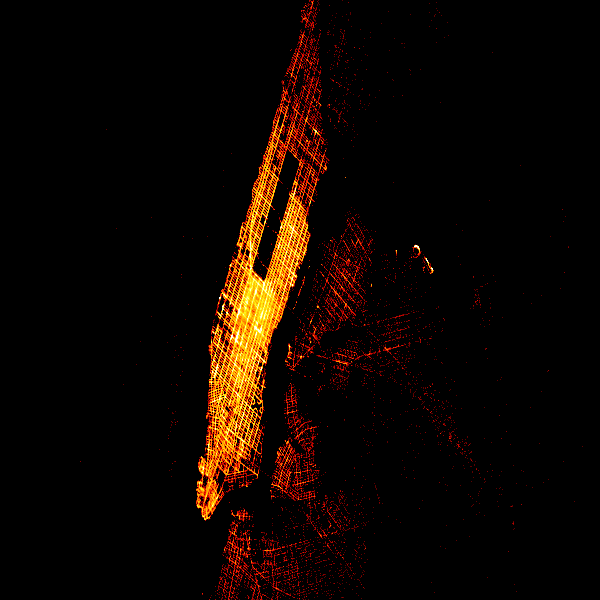

In [5]:
import datashader as ds
from colorcet import fire

# execute query & lay out a canvas w/ dropoff locations 
nyc = ds.Canvas().points(bc.sql('SELECT dropoff_x, dropoff_y FROM taxi'), 'dropoff_x', 'dropoff_y')

# shade in the picture w/ fire & display
ds.transfer_functions.set_background(ds.transfer_functions.shade(nyc, cmap=fire), "black")

#### cuML - RAPIDS Machine Learning Library

<details><summary>Learn more...</summary>

cuML is a suite of libraries that implement machine learning algorithms and mathematical primitives functions that share compatible APIs with other RAPIDS projects.

cuML enables data scientists, researchers, and software engineers to run traditional tabular ML tasks on GPUs without going into the details of CUDA programming. In most cases, cuML's Python API matches the API from scikit-learn.

For large datasets, these GPU-based implementations can complete 10-50x faster than their CPU equivalents. For details on performance, see the cuML Benchmarks Notebook.
    
[GitHub](https://github.com/rapidsai/cuml) | [Intro Notebook](intro_notebooks/cuml.ipynb)

</details>

In [6]:
%%time
from cuml import LinearRegression
from cuml.preprocessing.model_selection import train_test_split

# pull feature (X) and target (y) values
X = bc.sql('SELECT trip_distance, tolls_amount FROM taxi')
y = bc.sql('SELECT fare_amount FROM taxi')['fare_amount']

# split data into train and test sets (80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)

CPU times: user 690 ms, sys: 298 ms, total: 988 ms
Wall time: 934 ms


In [7]:
%%time
# call Linear Regression model
lr = LinearRegression()

# train the model
lr.fit(X_train, y_train)

# make predictions for test X values
y_pred = lr.predict(X_test)

CPU times: user 398 ms, sys: 124 ms, total: 523 ms
Wall time: 547 ms


In [8]:
from sklearn.metrics import r2_score
# convert test & predicted values to pandas series for r2_score
r2_score(y_true=y_test.to_pandas(), y_pred=y_pred.to_pandas())

0.2259499355768373

#### cuSignal - GPU-Accelerated Signal Processing

<details><summary>Learn more...</summary>

The RAPIDS cuSignal project leverages CuPy, Numba, and the RAPIDS ecosystem for GPU accelerated signal processing. 
    
In some cases, cuSignal is a direct port of Scipy Signal to leverage GPU compute resources via CuPy but also contains Numba CUDA kernels for additional speedups for selected functions. 
    
cuSignal achieves its best gains on large signals and compute intensive functions but stresses online processing with zero-copy memory (pinned, mapped) between CPU and GPU.

[GitHub](https://github.com/rapidsai/cusignal) | [Intro Notebook](intro_notebooks/cusignal.ipynb)

</details>

In [9]:
import cusignal
import cupy as cp

start = 0
stop = 10
num_samps = int(1e8)
resample_up = 2
resample_down = 3

gx = cp.linspace(start, stop, num_samps, endpoint=False) 
gy = cp.cos(-gx**2/6.0)

gf = cusignal.resample_poly(gy, resample_up, resample_down, window=('kaiser', 0.5))

In [10]:
gf

array([ 0.84210917,  1.05803451,  0.98243487, ..., -0.56449014,
       -0.60792788, -0.48386073])

#### cuGraph - RAPIDS Graph Analytics Library

Pending resolution of [rapidsai/cugraph#744](https://github.com/rapidsai/cugraph/issues/744).

<details><summary>Learn more...</summary>

The RAPIDS cuGraph library is a collection of graph analytics that process data found in GPU Dataframes - see cuDF.

cuGraph aims to provide a NetworkX-like API that will be familiar to data scientists, so they can now build GPU-accelerated workflows more easily.
    
[GitHub](https://github.com/rapidsai/cugraph) | [Intro Notebook](intro_notebooks/cugraph.ipynb)

</details>

In [11]:
# import cugraph

# # assuming that data has been loaded into a cuDF (using read_csv) Dataframe
# # gdf = cudf.read_csv("graph_data.csv", names=["src", "dst"], dtype=["int32", "int32"] )
# bc.create_table('karate', f'{os.getcwd()}/data/karate.csv', names=["src", "dst"])
# # gdf = bc.sql('SELECT fare_amount, tip_amount FROM taxi')
# gdf = bc.sql('select src, dst from karate')
# # create a Graph using the source (src) and destination (dst) vertex pairs the GDF  
# G = cugraph.Graph()
# # G.add_edge_list(gdf, source='src', destination='dst')
# # G.add_edge_list(gdf, source='fare_amount', destination='tip_amount')

# # Call cugraph.pagerank to get the pagerank scores
# gdf_page = cugraph.pagerank(G)

# for i in range(len(gdf_page)):
#     print("vertex " + str(gdf_page['vertex'][i]) + " PageRank is " + str(gdf_page['pagerank'][i]))  

#### Storage Plugins - Scale Your Data

<details><summary>Learn more...</summary>
    
We think you should let data rest wherever it likes. Don't worry about synching, directly query files wherever they reside.

With the BlazingSQL Filesystem API, you can register and connect to multiple storage solutions. 

- [AWS](https://docs.blazingdb.com/docs/s3) 
- [Google Storage](https://docs.blazingdb.com/docs/google-cloud-storage)
- [HDFS](https://docs.blazingdb.com/docs/hdfs)

Once a filesystem is registered you can reference the user-defined file path when creating a new table off of a file.
    
[Docs](https://docs.blazingdb.com/docs/connecting-data-sources) | [Intro notebook](intro_notebooks/storage_plugins.ipynb)
    
</details>

In [12]:
# # register an AWS S3 bucket
# bc.s3('bsql_data', bucket_name='blazingsql-colab', access_key_id='', secret_key='')

# # create table from S3 bucket
# bc.create_table('orders', 's3://bsql_data/tpch_sf1/orders/0_0_0.parquet')

# # query table from S3 bucket
# bc.sql('select * from orders')

#### BlazingSQL Logs

<details><summary>Learn more...</summary>
    
BlazingSQL has an internal log that records events from every node from all queries run. The events include runtime query step execution information, performance timings, errors and warnings. 

The logs table is called `bsql_logs`. You can query the logs as if it were any other table, except you use the `.log()` function, instead of the `.sql()` function.
    
[Docs](https://docs.blazingdb.com/docs/blazingsql-logs) | [Intro Notebook](intro_notebooks/bsql_logs.ipynb)
    
</details>

In [13]:
# how long did each successfully run query take?
bc.log("SELECT log_time, query_id, duration FROM bsql_logs WHERE info = 'Query Execution Done' ORDER BY log_time DESC")

,log_time,query_id,duration
0,2020-03-16 21:21:59,42956,473.597961
1,2020-03-16 21:21:59,12989,250.033615
2,2020-03-16 21:21:57,50266,271.636475
3,2020-03-16 21:21:55,26628,487.546143
4,2020-03-16 21:21:55,351,456.921021
...,...,...,...
786,2020-03-10 21:33:04,60865,1235.057983
787,2020-03-10 21:32:44,26309,11.578487
788,2020-03-10 21:32:37,59691,12.673598
789,2020-03-10 21:30:47,46195,13.415771


#### Cyber Log Accelerators 

RAPIDS Cyber Log Accelerators (CLX)

<details><summary>Learn more...</summary>
    
CLX ("clicks") provides a collection of RAPIDS examples for security analysts, data scientists, and engineers to quickly get started applying RAPIDS and GPU acceleration to real-world cybersecurity use cases.

The goal of CLX is to:

- Allow cyber data scientists and SecOps teams to generate workflows, using cyber-specific GPU-accelerated primitives and methods, that let them interact with code using security language,
- Make available pre-built use cases that demonstrate CLX and RAPIDS functionality that are ready to use in a Security Operations Center (SOC),
- Accelerate log parsing in a flexible, non-regex method. and
- Provide SIEM integration with GPU compute environments via RAPIDS and effectively extend the SIEM environment.
    
[GitHub](https://github.com/rapidsai/clx) | [Intro Notebook](intro_notebooks/clx.ipynb)
    
</details>

In [14]:
import cudf
import s3fs
from os import path

# download data
if not path.exists("./splunk_faker_raw4"):
    fs = s3fs.S3FileSystem(anon=True)
    fs.get("rapidsai-data/cyber/clx/splunk_faker_raw4", "./splunk_faker_raw4")

# read in alert data
gdf = cudf.read_csv('./splunk_faker_raw4')
gdf.columns = ['raw']

# parse the alert data using CLX built-in parsers
from clx.parsers.splunk_notable_parser import SplunkNotableParser

snp = SplunkNotableParser()
parsed_gdf = cudf.DataFrame()
parsed_gdf = snp.parse(gdf, 'raw')

# define function to round time to the day
def round2day(epoch_time):
    return int(epoch_time/86400)*86400

# aggregate alerts by day
parsed_gdf['time'] = parsed_gdf['time'].astype(int)
parsed_gdf['day'] = parsed_gdf.time.applymap(round2day)
day_rule_gdf = parsed_gdf[['search_name','day','time']].groupby(['search_name', 'day']).count().reset_index()
day_rule_gdf.columns = ['rule', 'day', 'count']

# import the rolling z-score function from CLX statistics
from clx.analytics.stats import rzscore

# pivot the alert data so each rule is a column
def pivot_table(gdf, index_col, piv_col, v_col):
    index_list = gdf[index_col].unique()
    piv_gdf = cudf.DataFrame()
    piv_gdf[index_col] = index_list
    for group in gdf[piv_col].unique():
        
        temp_df = gdf[gdf[piv_col] == group]
        temp_df = temp_df[[index_col, v_col]]
        temp_df.columns = [index_col, group]
        piv_gdf = piv_gdf.merge(temp_df, on=[index_col], how='left')
        
    piv_gdf = piv_gdf.set_index(index_col)
    return piv_gdf.sort_index()

alerts_per_day_piv = pivot_table(day_rule_gdf, 'day', 'rule', 'count').fillna(0)

# create a new cuDF with the rolling z-score values calculated
r_zscores = cudf.DataFrame()
for rule in alerts_per_day_piv.columns:
    x = alerts_per_day_piv[rule]
    r_zscores[rule] = rzscore(x, 7) #7 day window

In [15]:
r_zscores

,Access - Brute Force Access Behavior Detected - Rule,Access - Geographically Improbable Access Detected - Rule,Access - Privileged User Accessing More Than Expected Number of Machines in Period - Rule,Access - Short-lived Account Detected - Rule,Access - Silver Bullet for InfoSec Algo - Machine Learning,Audit - Indexes not receiving data - Rule,Endpoint - Brute Force against Known User - Rule,Endpoint - FireEye NX alert for Incident Review - Rule,Endpoint - Host With Malware Detected (Quarantined or Waived) - Rule,Endpoint - Host With Malware Detected - Rule,...,Splunk - Detection of DNS Tunnels - Rule,Threat - Authenticated communication from a risky source network - system - Rule,Threat - Beta Testing - Machine Learning,Threat - Compromised account - Rule,Threat - File Name Matches - Threat Gen,Threat - FireEye NX alert for Incident Review - Rule,Threat - Host not sending data - Rule,Threat - Magic Artifical Intelligence Algo - Machine Learning,Threat - Network Resolution Matches - Threat Gen,Threat - Source And Destination Matches - Threat Gen
day,,,,,,,,,,,,,,,,,,,,,
1546300800,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null
1546387200,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null
1546473600,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null
1546560000,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null
1546646400,null,null,null,null,null,null,null,null,null,null,...,null,null,null,null,null,null,null,null,null,null
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1568332800,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568419200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1568505600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
temp_df

NameError: name 'temp_df' is not defined

In [ ]:
day_rule_gdf